# Prep and EDA

## Prompt
Use the dataset below to build a model for a fictive stakeholder or user that you decide. You will present the results from what you built for myself and my colleague, wherein we will discuss around the results and the different steps. We see this as a good way for you to showcase your skills and to have a natural and practical dialogue about data science. We want you to focus on any freetext fields as main data source for the model and put in special focus around the usecase itself, explaining the results and the considerations that went in as part of the analysis. You could either choose from our example below or create your own. You set the ambition level for the assignment yourself.

If you have any questions or need any input along the way, don’t hesitate to contact us.

Dataset:
- https://www.yelp.com/dataset  (Yelp review dataset) (we have looked at the license and you’re allowed to use it for this assignment)

Example:
- Predict product category using review text? Does it help to also include other fields such as tip or location.

### Planning
#### Steps
1) Determine the fictive stakeholers / users and what they may want 
2) Review the data / EDA
3) Determine use cases
4) Clean the data
5) Feature engineering as necessary for various use cases
6) Design / Build models
7) Evaluate models

#### Goals
1) Showcase DS skills
2) Have a natural / practical dialogue about DS

#### Constraints
1) Focus on **any** free text fields as the main data source for the model
2) Focus on the usecase, explaining the results and considerations that went into the work

# Data
* business.json:
  * PrimaryKey: **business_id**
  * Contains business data including location data, attributes, and categories.
* review.json:
  * PrimaryKey: **review_id**
  * Contains full review text data including the user_id that wrote the review and the business_id the review is written for.
* user.json:
  * PrimaryKey: **user_id**
  * User data including the user's friend mapping and all the metadata associated with the user.
* checkin.json:
  * PrimaryKey: **business_id**
  * Checkins on a business.
* tip.json:
  * PrimaryKey: **user_id**, **business_id**, **text**, **date**
  * Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.
* photo.json:
  * PrimaryKey: **photo_id**
  * Contains photo data including the caption and classification (one of "food", "drink", "menu", "inside" or "outside").
 
Currently, the metropolitan areas centered on Montreal, Calgary, Toronto, Pittsburgh, Charlotte, Urbana-Champaign, Phoenix, Las Vegas, Madison, and Cleveland, are included in the dataset.

[Dataset Documentation](https://www.yelp.com/dataset/documentation/main)

## Scratch ideas
1) Remove business with <X reviews
2) Only open businesses?
3) Start small (e.g. only english in Charlotte)
4) Use the text to categorize restaurants (pca visualization) and then recommend new restaurants to users based on current recommendations (or something totally different)
5) Review checker -- does review seem correct for business given othe reviews
   * Maybe for newer reviewers. Or to flag a review that seems anomalous
6) Useful vs. not useful reviews
7) Predict category based on review text
   * Probabaly easiest, but success is likely moderate given review similarity (e.g. Great service! Very quick!)
8) How has user sentiment changed over time for a business?

In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import string
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [2]:
first_run = False
if first_run:
    !python json_to_csv_converter_py3.py yelp_dataset/yelp_academic_dataset_business.json
    !python json_to_csv_converter_py3.py yelp_dataset/yelp_academic_dataset_checkin.json
    !python json_to_csv_converter_py3.py yelp_dataset/yelp_academic_dataset_review.json
    !python json_to_csv_converter_py3.py yelp_dataset/yelp_academic_dataset_tip.json
    !python json_to_csv_converter_py3.py yelp_dataset/yelp_academic_dataset_user.json

In [3]:
data_import = True
if data_import:
    business = pd.read_csv("yelp_dataset/yelp_academic_dataset_business.csv", low_memory=False)

In [4]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 60 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   attributes.BYOB                        4439 non-null    object 
 1   hours                                  127123 non-null  object 
 2   state                                  150346 non-null  object 
 3   hours.Monday                           114474 non-null  object 
 4   attributes.ByAppointmentOnly           42299 non-null   object 
 5   name                                   150346 non-null  object 
 6   attributes.CoatCheck                   5580 non-null    object 
 7   attributes                             136602 non-null  object 
 8   attributes.WiFi                        56864 non-null   object 
 9   attributes.RestaurantsGoodForGroups    44149 non-null   object 
 10  attributes.RestaurantsTakeOut          57752 non-null   

In [5]:
business.describe()

,longitude,review_count,is_open,attributes.RestaurantsPriceRange2,latitude,stars
count,150346.000000,150346.000000,150346.00000,85280.000000,150346.000000,150346.000000
mean,-89.357339,44.866561,0.79615,1.767953,36.671150,3.596724
std,14.918502,121.120136,0.40286,0.646859,5.872759,0.974421
min,-120.095137,5.000000,0.00000,1.000000,27.555127,1.000000
25%,-90.357810,8.000000,1.00000,1.000000,32.187293,3.000000
50%,-86.121179,15.000000,1.00000,2.000000,38.777413,3.500000
75%,-75.421542,37.000000,1.00000,2.000000,39.954036,4.500000
max,-73.200457,7568.000000,1.00000,4.000000,53.679197,5.000000


# Data cleaning and preprocessing
## Business data

In [6]:
business.head(3)

,attributes.BYOB,hours,state,hours.Monday,attributes.ByAppointmentOnly,name,attributes.CoatCheck,attributes,attributes.WiFi,attributes.RestaurantsGoodForGroups,attributes.RestaurantsTakeOut,attributes.HappyHour,attributes.GoodForDancing,attributes.BusinessAcceptsBitcoin,longitude,attributes.BusinessParking,attributes.WheelchairAccessible,review_count,is_open,attributes.Smoking,attributes.GoodForKids,attributes.RestaurantsCounterService,attributes.RestaurantsPriceRange2,address,hours.Sunday,city,hours.Wednesday,hours.Tuesday,hours.Friday,attributes.Alcohol,hours.Thursday,attributes.AcceptsInsurance,latitude,attributes.HairSpecializesIn,attributes.HasTV,attributes.NoiseLevel,attributes.BYOBCorkage,attributes.RestaurantsAttire,categories,attributes.Ambience,attributes.BikeParking,attributes.BestNights,attributes.GoodForMeal,attributes.Open24Hours,attributes.RestaurantsTableService,attributes.RestaurantsDelivery,attributes.Corkage,hours.Saturday,attributes.RestaurantsReservations,attributes.OutdoorSeating,attributes.Music,attributes.AgesAllowed,attributes.BusinessAcceptsCreditCards,stars,attributes.DietaryRestrictions,attributes.DriveThru,attributes.DogsAllowed,postal_code,business_id,attributes.Caters
0,NaN,NaN,CA,NaN,True,"Abby Rappoport, LAC, CMQ",NaN,{'ByAppointmentOnly': 'True'},NaN,NaN,NaN,NaN,NaN,NaN,-119.711197,NaN,NaN,7,0,NaN,NaN,NaN,NaN,"1616 Chapala St, Ste 2",NaN,Santa Barbara,NaN,NaN,NaN,NaN,NaN,NaN,34.426679,NaN,NaN,NaN,NaN,NaN,"Doctors, Traditional Chinese Medicine, Naturop...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,93101,Pns2l4eNsfO8kk83dixA6A,NaN
1,NaN,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",MO,0:0-0:0,NaN,The UPS Store,NaN,{'BusinessAcceptsCreditCards': 'True'},NaN,NaN,NaN,NaN,NaN,NaN,-90.335695,NaN,NaN,15,1,NaN,NaN,NaN,NaN,87 Grasso Plaza Shopping Center,NaN,Affton,8:0-18:30,8:0-18:30,8:0-18:30,NaN,8:0-18:30,NaN,38.551126,NaN,NaN,NaN,NaN,NaN,"Shipping Centers, Local Services, Notaries, Ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8:0-14:0,NaN,NaN,NaN,NaN,True,3.0,NaN,NaN,NaN,63123,mpf3x-BjTdTEA3yCZrAYPw,NaN
2,NaN,"{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...",AZ,8:0-22:0,False,Target,False,"{'BikeParking': 'True', 'BusinessAcceptsCredit...",u'no',NaN,False,False,NaN,NaN,-110.880452,"{'garage': False, 'street': False, 'validated'...",True,22,0,NaN,NaN,NaN,2.0,5255 E Broadway Blvd,8:0-22:0,Tucson,8:0-22:0,8:0-22:0,8:0-23:0,NaN,8:0-22:0,NaN,32.223236,NaN,False,NaN,NaN,NaN,"Department Stores, Shopping, Fashion, Home & G...",NaN,True,NaN,NaN,NaN,NaN,False,NaN,8:0-23:0,False,False,NaN,NaN,True,3.5,NaN,NaN,False,85711,tUFrWirKiKi_TAnsVWINQQ,False


In [7]:
# drop duplicates
# Note that I spot checked busiensses with the same address -- these appear to not be duplicates but are malls, etc.
business.drop_duplicates('business_id', inplace=True)
business['address'].value_counts().head()

address
160 N Gulph Rd             86
51 N 12th St               55
1 Terminal Dr              52
4100 George J Bean Pkwy    46
222 E Market St            42
Name: count, dtype: int64

In [8]:
# drop various columns that are not necessary
# attributes.BusinessParking: likely not necessary for our purposes. Also messy json with NaNs
# attributes.HairSpecializesIn: Same as above
# attributes.Open24Hours: Too few values
# attributes.AgesAllowed: Too few values
# attributes.BusinessAcceptsCreditCards: Irrelevant
# attributes.DietaryRestrictions: Too few values
biz_columns_to_drop = ['hours', 'attributes', 'attributes.BusinessParking', 'attributes.HairSpecializesIn', 'attributes.RestaurantsAttire', 'attributes.BestNights',
                       'attributes.Open24Hours', 'attributes.Music', 'attributes.AgesAllowed', 'attributes.BusinessAcceptsCreditCards', 'attributes.DietaryRestrictions']
for column in biz_columns_to_drop:
    business.drop(column, inplace=True, axis=1)
business.reset_index(inplace=True, drop=True)

In [9]:
# Likely not necessary, but updating unicode string import issue leading to leading 'u's
unicode_fix_columns = ['attributes.Alcohol', 'attributes.Smoking', 'attributes.NoiseLevel', 'attributes.BYOBCorkage']

for column in unicode_fix_columns:
    business[column] = business[column].str.lstrip('u').str.strip()

# Update names to strip punctuation and lowercase
business['name'] = business['name'].str.strip().str.lower().str.translate(str.maketrans('', '', string.punctuation))

# Updating corkage to fix duplicate values
business['attributes.BYOBCorkage'] = business['attributes.BYOBCorkage'].str.split('_').str[0].value_counts()

In [10]:
#Looks like no null values here. Also checked type to confirm
print(business['latitude'].shape[0])
print(business['longitude'].shape[0])
print(business['state'].shape[0])
print(business['city'].shape[0])
print(business['postal_code'].shape[0])
print(business['business_id'].shape[0])

150346
150346
150346
150346
150346
150346


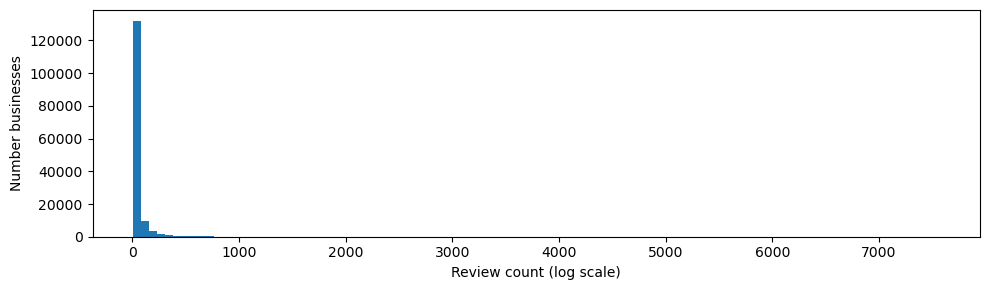

count    150346.000000
mean         44.866561
std         121.120136
min           5.000000
25%           8.000000
50%          15.000000
75%          37.000000
max        7568.000000
Name: review_count, dtype: float64


In [11]:
#Looks like businesses all have >= 5 reviews with significant outliers
fig, ax = plt.subplots(figsize=(10,3))
ax.hist(business['review_count'], bins=100)
ax.set_ylabel('Number businesses')
ax.set_xlabel('Review count (log scale)')
fig.tight_layout()
plt.show()
print(business['review_count'].describe())

### Narrowing scope to restaurants in PA only
This is being done to hone in on various POC solutions without working with the entire dataset

As shown below, restaurants comprise a large portion of the dataset and PA is the largest geography

In [12]:
# How many businesses are restaurants? We need a good way to figure this out.
# assuming that restaurantpricerange is a good proxy for is_restaurant
restaurant_test = business[~business['attributes.RestaurantsPriceRange2'].isna()]
restaurant_test['name'].value_counts().head(10)

name
mcdonalds        696
starbucks        619
dunkin           482
subway           446
taco bell        349
wendys           325
burger king      322
walgreens        310
cvs pharmacy     305
dominos pizza    289
Name: count, dtype: int64

Overall, this looks really messy and includes a number of non-restaurants (e.g. cvs pharmacy, etc.)

In [13]:
# Categories are listed as a single comma seperated string. Need to break them into a list.
# Note that the data isn't very clean so the type is not consistent. Need try/except block to account for this.
def split_categories(categories):
    try:
        output = categories.split(',')
        return [x.strip().lower() for x in output]
    except:
        return ""
        
business['category_split'] = business.apply(lambda row: split_categories(row['categories']), axis=1)

In [14]:
business['category_split'].explode().value_counts().head(20)

category_split
restaurants                  52268
food                         27781
shopping                     24395
home services                14356
beauty & spas                14292
nightlife                    12281
health & medical             11890
local services               11198
bars                         11065
automotive                   10773
event planning & services     9895
sandwiches                    8366
american (traditional)        8139
active life                   7687
pizza                         7093
coffee & tea                  6703
fast food                     6472
breakfast & brunch            6239
american (new)                6097
hotels & travel               5857
Name: count, dtype: int64

In [15]:
# Should I filter out fast food? 
categories_to_check = ['restaurants', 'food', 'bars', 'fast food']
business['applicable_categories'] = business['category_split'].apply(lambda x : 1 if any(i in x for i in categories_to_check) else 0)
filtered_businesses = business[business['applicable_categories'] == 1]

In [16]:
print("There are a total of {num_remaining} businesses from an original total of {total}".format(num_remaining = filtered_businesses.shape[0],
                                                                                                 total = business.shape[0]))

There are a total of 66770 businesses from an original total of 150346


state
PA    15826
FL    11261
TN     5460
MO     5283
IN     5270
LA     4845
NJ     4173
Name: count, dtype: int64


C:\Users\chreddin\AppData\Local\Temp\ipykernel_31260\3289857064.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


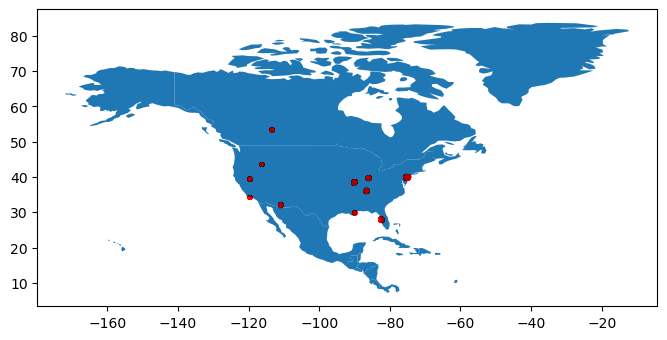

In [17]:
# most of these appear to be in PA and FL
print(filtered_businesses['state'].value_counts().head(7))

# Mapping to confirm 
lat_lon = filtered_businesses[['longitude', 'latitude']]
geometry = gpd.points_from_xy(lat_lon['longitude'], lat_lon['latitude'])
gdf = GeoDataFrame(lat_lon, geometry=geometry)   
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world['continent'] == 'North America']
gdf.plot(ax=north_america.plot(figsize=(8, 8)), marker='o', color='red', markersize=5, alpha=0.01);

In [18]:
# Filtering for just restaurants in PA for POC
filtered_businesses_PA = filtered_businesses[filtered_businesses['state'] == 'PA']

There are a total of 15826 businesses from an original total of 150346


C:\Users\chreddin\AppData\Local\Temp\ipykernel_31260\1502510473.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


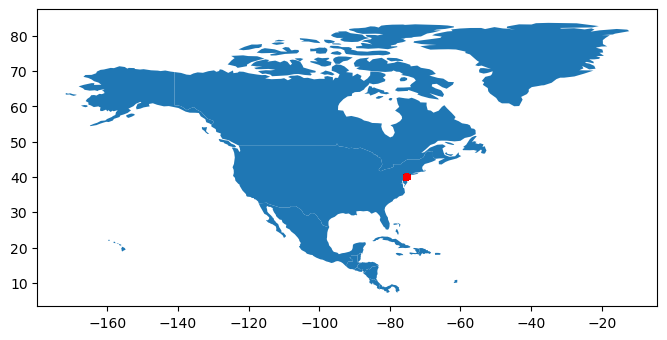

In [19]:
print("There are a total of {num_remaining} businesses from an original total of {total}".format(num_remaining = filtered_businesses_PA.shape[0],
                                                                                                 total = business.shape[0]))

# Mapping to confirm 
lat_lon = filtered_businesses_PA[['longitude', 'latitude']]
geometry = gpd.points_from_xy(lat_lon['longitude'], lat_lon['latitude'])
gdf = GeoDataFrame(lat_lon, geometry=geometry)   
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world['continent'] == 'North America']
gdf.plot(ax=north_america.plot(figsize=(8, 8)), marker='o', color='red', markersize=5, alpha=1);

## User review data

In [20]:
if data_import:
    reviews = pd.read_csv("yelp_dataset/yelp_academic_dataset_review.csv")

In [21]:
reviews.shape[0]

6990280

In [22]:
reviews.head()

,review_id,stars,cool,funny,useful,date,business_id,user_id,text
0,KU_O5udG6zpxOg-VcAEodg,3.0,0,0,0,2018-07-07 22:09:11,XQfwVwDr-v0ZS3_CbbE5Xw,mh_-eMZ6K5RLWhZyISBhwA,"If you decide to eat here, just be aware it is..."
1,BiTunyQ73aT9WBnpR9DZGw,5.0,1,0,1,2012-01-03 15:28:18,7ATYjTIgM3jUlt4UM3IypQ,OyoGAe7OKpv6SyGZT5g77Q,I've taken a lot of spin classes over the year...
2,saUsX_uimxRlCVr67Z4Jig,3.0,0,0,0,2014-02-05 20:30:30,YjUWPpI6HXG530lwP-fb2A,8g_iMtfSiwikVnbP2etR0A,Family diner. Had the buffet. Eclectic assortm...
3,AqPFMleE6RsU23_auESxiA,5.0,1,0,1,2015-01-04 00:01:03,kxX2SOes4o-D3ZQBkiMRfA,_7bHUi9Uuf5__HHc_Q8guQ,"Wow! Yummy, different, delicious. Our favo..."
4,Sx8TMOWLNuJBWer-0pcmoA,4.0,1,0,1,2017-01-14 20:54:15,e4Vwtrqf-wpJfwesgvdgxQ,bcjbaE6dDog4jkNY91ncLQ,Cute interior and owner (?) gave us tour of up...


In [23]:
filtered_reviews = reviews[reviews['business_id'].isin(filtered_businesses_PA['business_id'])].copy()

In [24]:
# drop duplicates
filtered_reviews.drop_duplicates('review_id', inplace=True)
# Removing any additional duplicate reviews from same user with same text and business
filtered_reviews.drop_duplicates(['business_id', 'user_id', 'text'], inplace=True)
# filtered_reviews.reset_index(drop=True, inplace=True)
# Cleaning up text field
filtered_reviews['text'] = filtered_reviews['text'].str.lstrip('u').str.strip().str.lower().str.translate(str.maketrans('-', ' ', string.punctuation))
# Removing escaped characters that show up literally
filtered_reviews['text'] = filtered_reviews['text'].str.translate(str.maketrans(dict([(chr(char), ' ') for char in range(1, 32)])))
# Removing >1 whitespace chars
def clean_whitespace(text):
    return ' '.join(text.split())
filtered_reviews['text'] = filtered_reviews.apply(lambda row: clean_whitespace(row['text']), axis=1)
# Dropping few reviews that are NaN
filtered_reviews = filtered_reviews[~filtered_reviews['text'].isna()]

In [25]:
# Looking nice and clean!
filtered_reviews['text']

0          if you decide to eat here just be aware it is ...
3          wow yummy different delicious our favorite is ...
5          i am a long term frequent customer of this est...
7          amazingly amazing wings and homemade bleu chee...
13         good foodloved the gnocchi with marinara the b...
                                 ...                        
6990255    i was so excited about all the food i saw but ...
6990260    later yelp ive only been here once but i love ...
6990265    ice cream ice cream sodas sundaes wanted to sh...
6990269    this is a good pizza option they deliver throu...
6990272    it is very rare for a restaurant to be this go...
Name: text, Length: 1203383, dtype: object

In [26]:
filtered_reviews.shape[0]

1203383

In [27]:
#Looking into review length
def num_review_words(text):
    return len(text.split(' '))
filtered_reviews['review_words'] = filtered_reviews.apply(lambda row: num_review_words(row['text']), axis=1)

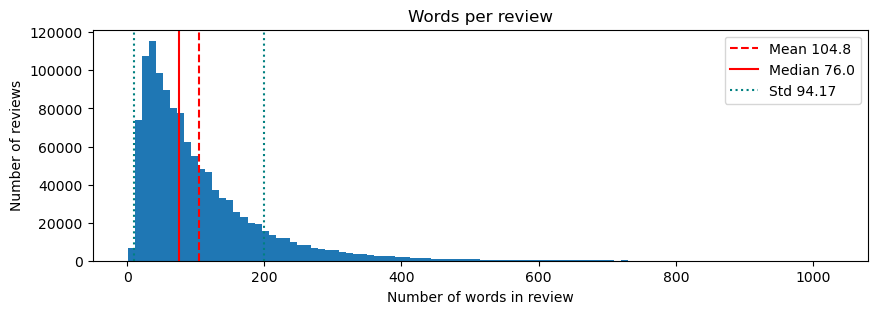

In [28]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.hist(filtered_reviews['review_words'], bins=100)
plt.axvline(x=filtered_reviews['review_words'].mean(), 
            color = 'red', 
            linestyle = '--', 
            label='Mean {}'.format(round(filtered_reviews['review_words'].mean(), 2)))
plt.axvline(x=filtered_reviews['review_words'].median(), 
            color = 'red', 
            linestyle = '-', 
            label='Median {}'.format(round(filtered_reviews['review_words'].median(), 2)))
plt.axvline(x= filtered_reviews['review_words'].mean() - filtered_reviews['review_words'].std(), 
            color = 'teal', 
            linestyle = ':')
plt.axvline(x= filtered_reviews['review_words'].mean() + filtered_reviews['review_words'].std(), 
            color = 'teal', 
            linestyle = ':', 
            label='Std {}'.format(round(filtered_reviews['review_words'].std(), 2)))
# ax.set_yscale('log')
ax.set_xlabel('Number of words in review')
ax.set_ylabel('Number of reviews')
ax.set_title('Words per review')
plt.legend()
plt.show()

In [29]:
# A quick check shows that the reviews look pretty good
print(filtered_reviews[filtered_reviews['review_words'] < 10]['text'].head(10).values)
print(filtered_reviews[filtered_reviews['review_words'] > 300]['text'].head(3).values)

['great weekday buffet mattar paneer was off the hook'
 'best pizza on lower main line great friendly staff'
 'they have good nonpariel cookies'
 'love the vegetarian burger the desserts are alright'
 'overpriced and completely overwhelming dont bother'
 'pretty good cajun options in the middle of philadelphia'
 'good authentic mexican foodcant go wrong here'
 'best bagels in the greater philadelphia area'
 'ridiculous prices for small portionslittle meatmostly rice'
 'beautiful venue good music and great people']
['the only reason i didnt give this restaurant a 5 star rating is because of one single pretentious waiter as a 4 night guest at hotel palomar the location of the restaurant is an obvious plus the first night of my stay i met a coworker in the restaurant for a cocktail when we arrived the host staff were busy and not available so we just walked in the restaurant was not too busy so we just looked at a small table next to the bar and proceeded to take a seat a waiter came by a

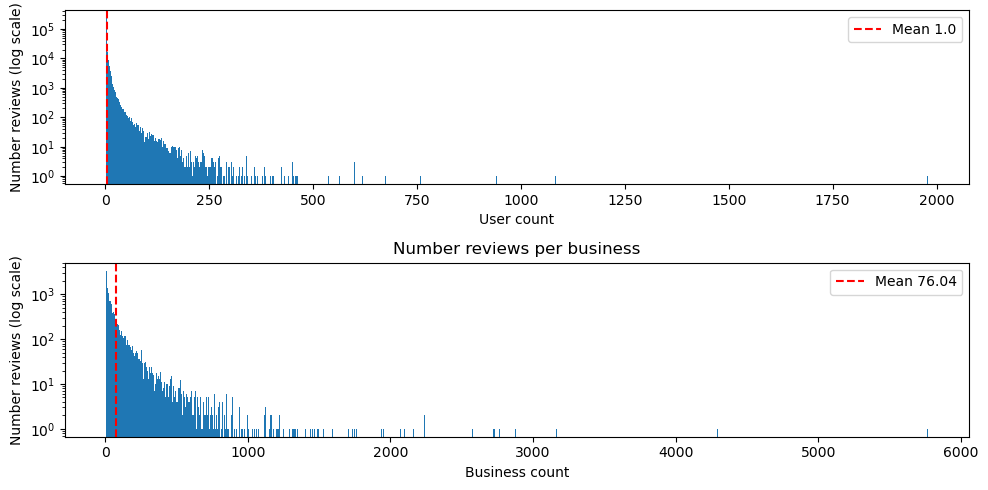

In [30]:
# Looking at distribution of reviews by person
fig, axs = plt.subplots(2, 1, figsize=(10,5))
reviews_by_user = filtered_reviews['user_id'].value_counts()
reviews_by_business = filtered_reviews['business_id'].value_counts()
axs[0].hist(reviews_by_user, bins=1000)
axs[0].axvline(x=reviews_by_user.mean(), 
            color = 'red', 
            linestyle = '--',
            label='Mean {}'.format(round(reviews_by_user.median(), 2)))
axs[0].legend()
axs[0].set_yscale('log')
axs[0].set_ylabel('Number reviews (log scale)')
axs[0].set_xlabel('User count')

axs[1].hist(reviews_by_business, bins=1000)
axs[1].axvline(x=reviews_by_business.mean(), 
            color = 'red', 
            linestyle = '--',
            label='Mean {}'.format(round(reviews_by_business.mean(), 2)))
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_ylabel('Number reviews (log scale)')
axs[1].set_xlabel('Business count')
axs[1].set_title('Number reviews per business')
fig.tight_layout()
plt.show()

What do we do with this information then? Should we treat power users, or popular businesses differently than the rest of the population. I'm thinking that likely not. We may want some filtering around the minimum number of reviews that a user or business should have (stretch: use a data-driven approach here) before we make a recommendation.

In [31]:
filtered_reviews['stars'].value_counts()

stars
5.0    486877
4.0    314697
3.0    151719
1.0    141409
2.0    108681
Name: count, dtype: int64

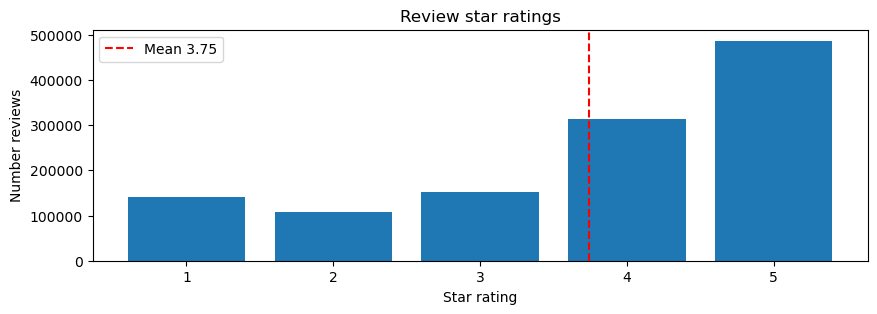

In [32]:
# Looking into the distribution of star ratings among reviews
fig, ax = plt.subplots(figsize=(10, 3))

ax.bar(x = filtered_reviews['stars'].value_counts().index, 
       height = filtered_reviews['stars'].value_counts().values, 
       align='center')

ax.axvline(x=filtered_reviews['stars'].mean(), 
            color = 'red', 
            linestyle = '--',
            label='Mean {mean}'.format(mean = round(filtered_reviews['stars'].mean(), 2)))
ax.set_ylabel('Number reviews')
ax.set_xlabel('Star rating')
ax.set_title('Review star ratings')
ax.legend()
plt.show()

Star reviews skew towards 5 stars and one stars, but mid values (2-4) are the majority. For the purpose of recommendation we could consider 4 & 5 stars as "good reviews" and everything below that as "bad". As a stretch goal, we could make this scalable (i.e. A 5-star review counts for more than a 4-star review, etc.)

Ok -- I think that we're at a spot now where we have the data cleaned up enough to start doing some modeling on the text.

In [33]:
filtered_reviews.shape[0]

1203383

## Outputting the filtered down datasets for use in other notebooks

In [34]:
filtered_reviews.to_csv('yelp_dataset/filtered_reviews_PA.tsv', sep='\t')
filtered_businesses_PA.to_csv('yelp_dataset/filtered_business_PA.tsv', sep='\t')